In [20]:
#KGAT_746a8c48819a19cbaf8ca0048244831b

In [21]:
!pip install opendatasets
!pip install pandas

Библиотеки

In [22]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Для задачи регрессии был взят датасет по ценам недвижимости.   Задача: предсказать стоимость объекта за единицу площади по его характеристикам. Данная модель может быть необходима агенствам, покупателям и продавцам жилья для оценки справедливости цены и анализа факторов, влияющих на цену

In [23]:
od.download("https://www.kaggle.com/datasets/kirbysasuke/house-price-prediction-simplified-for-regression")

Skipping, found downloaded files in "./house-price-prediction-simplified-for-regression" (use force=True to force download)


Чтение датасета и просмотр столбцов

In [24]:
pd.set_option("display.max_columns", None)
df = pd.read_csv("house-price-prediction-simplified-for-regression/Real_Estate.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Transaction date                     414 non-null    object 
 1   House age                            414 non-null    float64
 2   Distance to the nearest MRT station  414 non-null    float64
 3   Number of convenience stores         414 non-null    int64  
 4   Latitude                             414 non-null    float64
 5   Longitude                            414 non-null    float64
 6   House price of unit area             414 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 22.8+ KB


Приводим таргет к числовому типу, удаляя строки, которые не удалось конвертировать

In [25]:
df["House price of unit area"] = pd.to_numeric(df["House price of unit area"], errors="coerce")
df = df.dropna(subset=["House price of unit area"])

Проводим анализ данных на пропуски, дубликаты, выбросы  
IQR-метод нашел выбросы только в расстоянии до MRT, что я игнорирую, ведь это просто объекты, сильно удаленные от метро, и они тоже могут играть роль  
В House price of unit area есть цена 0, что может помешать модели, поэтому удаляем

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Transaction date                     414 non-null    object 
 1   House age                            414 non-null    float64
 2   Distance to the nearest MRT station  414 non-null    float64
 3   Number of convenience stores         414 non-null    int64  
 4   Latitude                             414 non-null    float64
 5   Longitude                            414 non-null    float64
 6   House price of unit area             414 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 22.8+ KB

Пропуски по столбцам:
Transaction date                       0
House age                              0
Distance to the nearest MRT station    0
Number of convenience stores           0
Latitude                               0
Longitude  

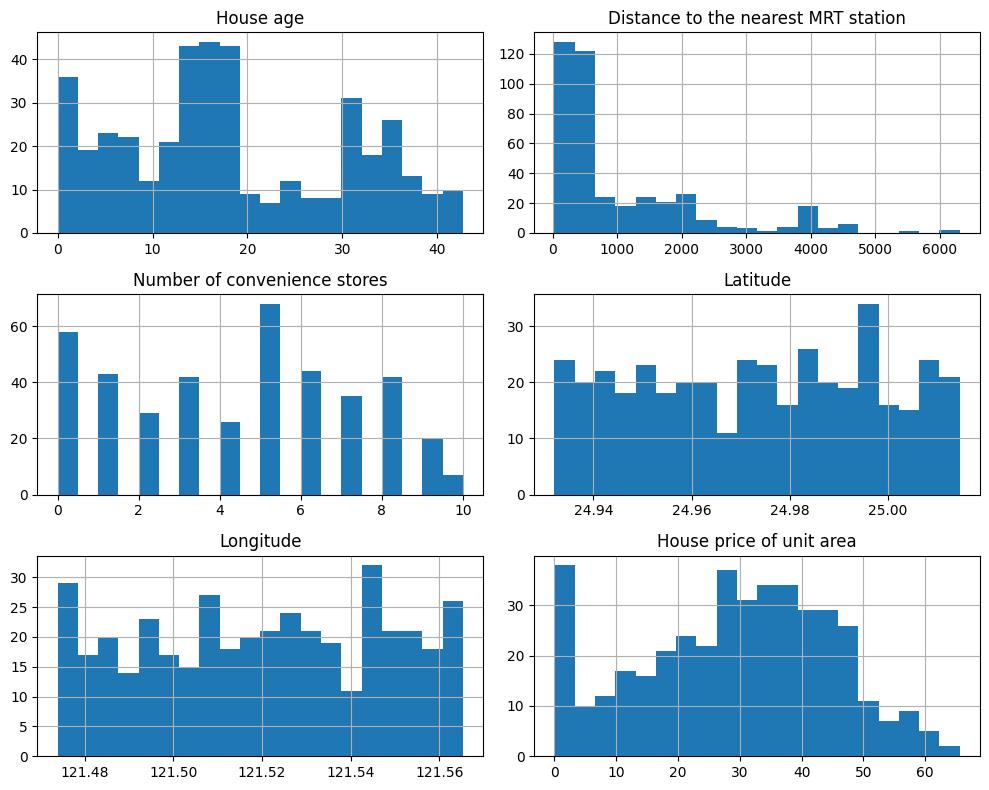

House age: потенциальных выбросов 0
Distance to the nearest MRT station: потенциальных выбросов 34
Number of convenience stores: потенциальных выбросов 0
Latitude: потенциальных выбросов 0
Longitude: потенциальных выбросов 0
House price of unit area: потенциальных выбросов 0

Всего строк, где есть хотя бы один потенциальный выброс: 34


In [26]:
df.info()

print("\nПропуски по столбцам:")
print(df.isna().sum().sort_values(ascending=False))
dup_count = df.duplicated().sum()
print("\nКоличество полностью дублирующихся строк:", dup_count)
print("\nЧисловые признаки:")
print(df.describe())

cols_to_check = [
    "House age",
    "Distance to the nearest MRT station",
    "Number of convenience stores",
    "Latitude",
    "Longitude",
    "House price of unit area",
]

for c in cols_to_check:
    print(f"{c}: min={df[c].min()}, max={df[c].max()}")
df[cols_to_check].hist(figsize=(10, 8), bins=20)
plt.tight_layout()
plt.show()
outlier_mask = pd.Series(False, index=df.index)

for c in cols_to_check:
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask_c = (df[c] < lower) | (df[c] > upper)
    print(f"{c}: потенциальных выбросов {mask_c.sum()}")
    outlier_mask |= mask_c

print("\nВсего строк, где есть хотя бы один потенциальный выброс:", outlier_mask.sum())


Удаляем объекты с нулевой ценой

In [27]:
df = df[df["House price of unit area"] > 0].copy()

Формируем признаки и целевую переменную  
Таргет - цена  
Признаки использую все, кроме цены и времени, осталяя только числовые характеристики

In [28]:
y = df["House price of unit area"]
X = df.drop(columns=["House price of unit area", "Transaction date"])

Обучаем бейзлайновую модель  
Оценим модель с помощью метрик:  
MAE - средняя абсолютная ошибка. Показывает, на сколько единиц в среднем модель ошибается в цене  
RMSE - корень из среднеквадратичной ошибки. Сильнее штрафует большие ошибки, чем MAE. Полезна при необходимости уменьшать крупные промахи  
R^2 - доля дисперсии таргета. 0 - модель предсказывает наугад, отрицательное значение означает, что модель предсказывает хуже, чем угадывание, а чем ближе к 1, тем лучше модель

Разбиваем данные на обучающую и тестовую выборки. Масштабирую все числовые признаки  
Возьмем модель из sklearn с параметрами 5 соседей и весами uniform  
Метрики:  
MAE 10.17 — в среднем модель ошибается примерно на 10 единиц цены, очень грубо  
RMSE 12.53 — чуть выше MAE, что отражает наличие более крупных ошибок  
R^2 0.13 — объясняется только около 13% вариации цен  
Модель дает грубые прогнозы, далее будем отталкиваться от неё и пытаться улучшить

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_cols = X.columns.tolist()
preprocessor_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
    ]
)

knn_reg_baseline = Pipeline(steps=[
    ("preprocess", preprocessor_reg),
    ("regressor", KNeighborsRegressor(n_neighbors=5, weights="uniform"))
])

knn_reg_baseline.fit(X_train, y_train)
y_pred_base = knn_reg_baseline.predict(X_test)

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print("Бейзлайн KNN-регрессор")
print("MAE:", mae_base)
print("RMSE:", rmse_base)
print("R^2:", r2_base)

Бейзлайн KNN-регрессор
MAE: 10.166462507808877
RMSE: 12.526868314301552
R^2: 0.13239610851129258


Первая гипотеза - улучшим качество за счет подбора гиперпараметров соседей и типа весов. Используем GridSearchCV с минимизацией MAE  
Результат:  
Для модели подобрались количество соседей 9 и тип весов distance  
На тесте MAE и RMSE снизились, а R^2 выросло  
Подбор таких гиперпараметров дает небольшое, но улучшение по сравнению с обычным выбором параметров

In [30]:
param_grid = {
    "regressor__n_neighbors": [3, 5, 7, 9, 11, 15],
    "regressor__weights": ["uniform", "distance"],
}

knn_reg_gs = GridSearchCV(
    estimator=knn_reg_baseline,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1
)

knn_reg_gs.fit(X_train, y_train)

print("Лучшие параметры:", knn_reg_gs.best_params_)
print("Лучший MAE на CV:", -knn_reg_gs.best_score_)

best_reg = knn_reg_gs.best_estimator_
y_pred_best = best_reg.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("\nУлучшенный KNN-регрессор")
print("MAE:", mae_best)
print("RMSE:", rmse_best)
print("R^2:", r2_best)


Лучшие параметры: {'regressor__n_neighbors': 9, 'regressor__weights': 'distance'}
Лучший MAE на CV: 10.102482207118468

Улучшенный KNN-регрессор
MAE: 9.80336811470678
RMSE: 12.168940152186943
R^2: 0.18126759916746082


Гипотеза 2 - взять вместо расстояния до метро его логарифм, так как в распределении данные неравномерные  
Результат оказался хуже, чем у бейзлайна с обычным расстоянием: MAE вырос с 10.17 до 10.39, RMSE тоже стал больше, а R^2 хоть и остался выше нуля (≈0.16), но хуже, чем у модели с подбором гиперпараметров без логарифмирования. То есть лог-преобразование расстояния до MRT в рамках KNN здесь не улучшает качество, а наоборот немного его портит - гипотезу о пользе замены distance - log(distance) для этой модели и этого датасета отвергаем

In [31]:
df_log = df.copy()
df_log["log_dist_MRT"] = np.log1p(df_log["Distance to the nearest MRT station"])

features_log = [
    "House age",
    "log_dist_MRT",
    "Number of convenience stores",
    "Latitude",
    "Longitude",
]

X_log = df_log[features_log]
y_log = df_log["House price of unit area"]

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log,
    test_size=0.2,
    random_state=42
)

num_cols_log = features_log

preprocessor_log = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_log),
    ]
)

knn_reg_log = Pipeline(steps=[
    ("preprocess", preprocessor_log),
    ("regressor", KNeighborsRegressor())
])

param_grid_log = {
    "regressor__n_neighbors": [3, 5, 7, 9, 11, 15],
    "regressor__weights": ["uniform", "distance"],
}

gs_log = GridSearchCV(
    estimator=knn_reg_log,
    param_grid=param_grid_log,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1
)

gs_log.fit(X_train_log, y_train_log)

print("Лучшие параметры:", gs_log.best_params_)
print("Лучший MAE на CV:", -gs_log.best_score_)

best_reg_log = gs_log.best_estimator_
y_pred_log = best_reg_log.predict(X_test_log)

mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)

print("\nKNN-регрессор с log(до MRT)")
print("MAE:", mae_log)
print("RMSE:", rmse_log)
print("R^2:", r2_log)


Лучшие параметры: {'regressor__n_neighbors': 15, 'regressor__weights': 'distance'}
Лучший MAE на CV: 9.936631369031481

KNN-регрессор с log(до MRT)
MAE: 10.38727832088338
RMSE: 12.29819900855221
R^2: 0.16378202214883408


3 гипотеза - логарифмирование таргета может помочь уменьшить влияние дорогих объектов  
Обучаю модель предсказывать цену в логарифмическом виде, а потом возвращаю ее в исходное состояние с помощью expm1  
Теперь лучшие гиперпараметры: соседи 15, веса distance  
MAE ≈ 9.70, RMSE ≈ 11.70 и R^2 ≈ 0.24 - лучше, чем у базового KNN и варианта только с подбором гиперпараметров, а также явно удачнее логарифмирования расстояния до MRT. То есть для библиотечной модели KNN логарифмирование таргета оказывается самой эффективной гипотезой для улучшения качества.

In [32]:
y_log = np.log1p(df["House price of unit area"])
X = df.drop(columns=["House price of unit area", "Transaction date"])

X_train, X_test, y_train_log, y_test = train_test_split(
    X, y_log,
    test_size=0.2,
    random_state=42
)

num_cols = X.columns.tolist()
preprocessor_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
    ]
)

knn_reg_log_y = Pipeline(steps=[
    ("preprocess", preprocessor_reg),
    ("regressor", KNeighborsRegressor())
])

param_grid_log_y = {
    "regressor__n_neighbors": [3, 5, 7, 9, 11, 15],
    "regressor__weights": ["uniform", "distance"],
}

gs_log_y = GridSearchCV(
    estimator=knn_reg_log_y,
    param_grid=param_grid_log_y,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1
)

gs_log_y.fit(X_train, y_train_log)

print("Лучшие параметры:", gs_log_y.best_params_)
print("Лучший MAE на CV:", -gs_log_y.best_score_)

best_log_y = gs_log_y.best_estimator_

y_pred_log = best_log_y.predict(X_test)
y_pred = np.expm1(y_pred_log)

mae_log_y = mean_absolute_error(df.loc[y_test.index, "House price of unit area"], y_pred)
rmse_log_y = np.sqrt(mean_squared_error(df.loc[y_test.index, "House price of unit area"], y_pred))
r2_log_y = r2_score(df.loc[y_test.index, "House price of unit area"], y_pred)

print("\nKNN-регрессор с логарифмом y")
print("MAE:", mae_log_y)
print("RMSE:", rmse_log_y)
print("R^2:", r2_log_y)


Лучшие параметры: {'regressor__n_neighbors': 15, 'regressor__weights': 'distance'}
Лучший MAE на CV: 0.36572277638910006

KNN-регрессор с логарифмом y
MAE: 9.700618617950706
RMSE: 11.703764034452638
R^2: 0.24266577859600302


Создадим свой собственный KNN регрессор  
В fit запоминает выборку для обучения. distance вычисляет матрицу попарных евклидовых расстояний между объектами в форме, удобной для векторизации. В predict для каждого тестового объекта нахожу индексы k ближайших соседей, извлекаю их целевые значения и считаю предсказание  
uniform - простое среднее по соседям  
distance - взвешенное среднее с весами, обратно пропорциональными расстоянию

In [33]:
class MyKNNRegressor(BaseEstimator, RegressorMixin):
  def __init__(self, neighbors=5, weights="uniform"):
    self.neighbors = neighbors
    self.weights = weights

  def fit(self, X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    self.X_train = X
    self.y_train = y
    return self

  def distance(self, X):
    X = np.asarray(X)
    sq_X = np.sum(X**2, axis=1)[:, np.newaxis]
    sq_X_train = np.sum(self.X_train**2, axis=1)[np.newaxis, :]
    cross = X @ self.X_train.T
    dists = np.sqrt(np.maximum(sq_X + sq_X_train - 2 * cross, 0.0))
    return dists

  def predict(self, X):
    X = np.asarray(X)
    dist = self.distance(X)
    n_test = X.shape[0]
    n_train = self.X_train.shape[0]
    k = min(self.neighbors, n_train)

    neigh_idx = np.argpartition(dist, k-1, axis=1)[:, :k]
    neigh_dist = np.take_along_axis(dist, neigh_idx, axis=1)
    neigh_y = self.y_train[neigh_idx]

    y_pred = np.zeros(n_test, dtype=float)

    for i in range(n_test):
      y_i = neigh_y[i]
      d_i = neigh_dist[i]

      if self.weights == "uniform":
        y_pred[i] = np.mean(y_i)
      elif self.weights == "distance":
        eps = 1e-8
        w = 1.0 / (d_i + eps)
        y_pred[i] = np.sum(w * y_i) / np.sum(w)
      else:
        raise ValueError("must be 'uniform' or 'distance'")

    return y_pred

Используем те же данные, что и при обучении бейзлайна, формируя таргет и матрицу признаков, разделяем тестовую и обучающую выборки и стандартизируем все числовые признаки

In [34]:
y = df["House price of unit area"]

X = df.drop(columns=["House price of unit area", "Transaction date"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

num_cols = X.columns.tolist()

preprocessor_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
    ]
)
y = df["House price of unit area"]

X = df.drop(columns=["House price of unit area", "Transaction date"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

num_cols = X.columns.tolist()

preprocessor_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
    ]
)

Обучаем собственную реализацию  
Метрики полностью совпадают с библиотечной моделью, значит, алгоритм корректно реализован

In [35]:
my_knn_base = Pipeline(steps=[
    ("preprocess", preprocessor_reg),
    ("regressor", MyKNNRegressor(neighbors=5, weights="uniform")),
])

my_knn_base.fit(X_train, y_train)
y_pred_mbase = my_knn_base.predict(X_test)

mae_mbase = mean_absolute_error(y_test, y_pred_mbase)
rmse_mbase = np.sqrt(mean_squared_error(y_test, y_pred_mbase))
r2_mbase = r2_score(y_test, y_pred_mbase)

print("MyKNNRegressor baseline (k=5, uniform)")
print("MAE:", mae_mbase)
print("RMSE:", rmse_mbase)
print("R^2:", r2_mbase)


MyKNNRegressor baseline (k=5, uniform)
MAE: 10.166462507808877
RMSE: 12.526868314301552
R^2: 0.13239610851129258


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


1 гипотеза, но для собственного регрессора  
Гиперпараметры совпали с библиотечным KNN
Значения метрик прилизительно равны реализации из sklearn, значит, моя реализация работает и дает такое же качество

In [36]:
my_knn1 = Pipeline(steps=[
    ("preprocess", preprocessor_reg),
    ("regressor", MyKNNRegressor()),
])

param_grid_1 = {
    "regressor__neighbors": [3, 5, 7, 9, 11, 15],
    "regressor__weights": ["uniform", "distance"],
}

grid_1 = GridSearchCV(
    estimator=my_knn1,
    param_grid=param_grid_1,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
)

grid_1.fit(X_train, y_train)

print("Лучшие параметры:", grid_1.best_params_)
print("Лучший MAE на CV:", -grid_1.best_score_)

best_my_knn1 = grid_1.best_estimator_
y_pred_my1 = best_my_knn1.predict(X_test)

mae_my1 = mean_absolute_error(y_test, y_pred_my1)
rmse_my1 = np.sqrt(mean_squared_error(y_test, y_pred_my1))
r2_my1 = r2_score(y_test, y_pred_my1)

print("\nMyKNNRegressor + подбор гиперпараметров")
print("MAE:", mae_my1)
print("RMSE:", rmse_my1)
print("R^2:", r2_my1)


Лучшие параметры: {'regressor__neighbors': 9, 'regressor__weights': 'distance'}
Лучший MAE на CV: 10.102482206750222

MyKNNRegressor + подбор гиперпараметров
MAE: 9.803368112620179
RMSE: 12.168940150928817
R^2: 0.18126759933675562


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Вторая гипотеза для собственной реализации. Подобрались такие же гиперпараметры, как и для библиотечной версии. Также, как в sklearn, эта гипотеза дала увеличение MAE, и уменьшение RMSE и R^2  
Метрики идетичны, значит, собственная модель работает, как из библиотеки

На кросс-валидации MAE чуть снизился относительно бейзлайна, но на тесте итоговое качество оказалось хуже: MAE вырос с 9.80 до 10.39 и даже стал немного больше, чем у исходного бейзлайна. При этом RMSE и R^2 всё ещё немного лучше бейзлайна, но заметно хуже первой гипотезы. В итоге логарифмирование расстояния до MRT для моей реализации KNN не даёт выигрыша по MAE и выглядит менее удачным, чем просто подбор k и схемы весов

In [37]:
df_log = df.copy()
df_log["log_dist_MRT"] = np.log1p(df_log["Distance to the nearest MRT station"])

y_logX = df_log["House price of unit area"]
X_logX = df_log.drop(columns=[
    "House price of unit area",
    "Transaction date",
    "Distance to the nearest MRT station"
])

X_train_logX, X_test_logX, y_train_logX, y_test_logX = train_test_split(
    X_logX, y_logX,
    test_size=0.2,
    random_state=42
)

num_cols_logX = X_logX.columns.tolist()

preprocessor_logX = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_logX),
    ]
)

my_knn2 = Pipeline(steps=[
    ("preprocess", preprocessor_logX),
    ("regressor", MyKNNRegressor()),
])

param_grid_2 = {
    "regressor__neighbors": [3, 5, 7, 9, 11, 15],
    "regressor__weights": ["uniform", "distance"],
}

grid_2 = GridSearchCV(
    estimator=my_knn2,
    param_grid=param_grid_2,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
)

grid_2.fit(X_train_logX, y_train_logX)

print("Лучшие параметры:", grid_2.best_params_)
print("Лучший MAE на CV:", -grid_2.best_score_)

best_my_knn2 = grid_2.best_estimator_
y_pred_my2 = best_my_knn2.predict(X_test_logX)

mae_my2 = mean_absolute_error(y_test_logX, y_pred_my2)
rmse_my2 = np.sqrt(mean_squared_error(y_test_logX, y_pred_my2))
r2_my2 = r2_score(y_test_logX, y_pred_my2)

print("\nMyKNNRegressor + log(distance)")
print("MAE:", mae_my2)
print("RMSE:", rmse_my2)
print("R^2:", r2_my2)


Лучшие параметры: {'regressor__neighbors': 15, 'regressor__weights': 'distance'}
Лучший MAE на CV: 9.936631369779763

MyKNNRegressor + log(distance)
MAE: 10.38727832003532
RMSE: 12.298199008259093
R^2: 0.1637820221886951


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Гипотеза 3  
На тесте это дало самый аккуратный результат среди всех вариантов моей реализации: MAE снизился до 9.70 (против 10.17 у бейзлайна и 9.80 у гипотезы 1), RMSE заметно уменьшился до 11.70, а R^2 вырос до ~0.24. То есть логарифмирование таргета действительно помогает KNN-регрессору лучше описывать вариацию цен и немного сокращает среднюю ошибку, так что эту гипотезу можно считать наиболее удачной для моей реализации

In [38]:
y_logtarget = np.log1p(df["House price of unit area"])
X_targ = df.drop(columns=["House price of unit area", "Transaction date"])

X_train_t, X_test_t, y_train_t, y_test_t_idx = train_test_split(
    X_targ, y_logtarget,
    test_size=0.2,
    random_state=42
)

num_cols_t = X_targ.columns.tolist()

preprocessor_t = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_t),
    ]
)

my_knn3 = Pipeline(steps=[
    ("preprocess", preprocessor_t),
    ("regressor", MyKNNRegressor()),
])

param_grid_3 = {
    "regressor__neighbors": [3, 5, 7, 9, 11, 15],
    "regressor__weights": ["uniform", "distance"],
}

grid_3 = GridSearchCV(
    estimator=my_knn3,
    param_grid=param_grid_3,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
)

grid_3.fit(X_train_t, y_train_t)

print("Лучшие параметры:", grid_3.best_params_)
print("Лучший MAE на CV:", -grid_3.best_score_)

best_my_knn3 = grid_3.best_estimator_

y_pred_log_t = best_my_knn3.predict(X_test_t)
y_pred_t = np.expm1(y_pred_log_t)

y_test_true = np.expm1(y_test_t_idx)

mae_my3 = mean_absolute_error(y_test_true, y_pred_t)
rmse_my3 = np.sqrt(mean_squared_error(y_test_true, y_pred_t))
r2_my3 = r2_score(y_test_true, y_pred_t)

print("\nMyKNNRegressor + log(target)")
print("MAE:", mae_my3)
print("RMSE:", rmse_my3)
print("R^2:", r2_my3)


Лучшие параметры: {'regressor__neighbors': 15, 'regressor__weights': 'distance'}
Лучший MAE на CV: 0.3657227763740669

MyKNNRegressor + log(target)
MAE: 9.700618616806302
RMSE: 11.703764033475368
R^2: 0.2426657787224783


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


В задаче регрессии я исследовала, как алгоритм KNN справляется с предсказанием цены недвижимости по набору простых числовых признаков. Базовый KNN-регрессор по качеству хромал. Средняя ошибка около 10 единиц цены и R^2 0.13. Подбор гиперпараметров немного улучшил метрики, а добавление логарифма расстояния до MRT позволило лучше объяснять вариацию цен за счёт роста R^2.

Наилучший результат дала гипотеза с логарифмированием целевой переменной. Она показала минимальные MAE и RMSE и максимальный R^2 среди всех вариантов. Собственная реализация KNN-регрессора при тех же настройках дала практически идентичные метрики по сравнению со стандартной, поэтому её можно считать корректной. В итоге качество сильно ограничено самим простым алгоритмом и небольшим набором признаков, а главный вклад в качество здесь дают не столько собственные реализации в коде, сколько аккуратный препроцессинг и настройки модели.